In [1]:
import pandas as pd
import scanpy as sc


In [2]:
pseudotime_df = pd.read_csv('/storage/lingyuan2/STATES_data/pseudotime_values.csv')
adata = sc.read_h5ad('/storage/lingyuan2/STATES_data/filtered_data.h5ad')
adata.obs['Pseudotime'] = pseudotime_df['Pseudotime'].values
adata.write('/storage/lingyuan2/STATES_data/pseudotime.h5ad')


In [4]:
adata = sc.read_h5ad('/storage/lingyuan2/STATES_data/pseudotime.h5ad')

In [2]:
pseudotime_df = pd.read_csv('/storage/lingyuan2/STATES_data/pseudotime_values2.csv')
adata = sc.read_h5ad('/storage/lingyuan2/STATES_data/filtered_data.h5ad')
adata.obs['Pseudotime'] = pseudotime_df['Pseudotime'].values
adata.write('/storage/lingyuan2/STATES_data/pseudotime2.h5ad')


In [3]:
adata = sc.read_h5ad('/storage/lingyuan2/STATES_data/pseudotime2.h5ad')

In [4]:
import numpy as np
adata.layers['totalRNA'] = adata.X.copy()
total_counts = adata.layers['totalRNA'].sum(axis=1)
median_reads = np.median(total_counts)
print(f"Median number of reads per cell: {median_reads}")
adata.layers['totalRNA_norm'] = sc.pp.normalize_total(adata, target_sum=median_reads, layer='totalRNA', inplace=False)['X']
adata.layers['TE'] = np.nan_to_num(adata.layers['TE'],nan=0.0)
adata.layers['rbRNA_norm'] = adata.layers['TE'] * adata.layers['totalRNA_norm']
sc.pp.log1p(adata, layer='rbRNA_norm')
sc.pp.log1p(adata, layer='totalRNA_norm')
sc.pp.log1p(adata, layer='TE')

Median number of reads per cell: 2203.0


In [12]:
adata.obs

,cell_id,region,area,condition,sample,TE_cell_mean,pass_volume_filter,pass_counts_filter,pass_two_filters,pass_density_filter,pass_all_filters,Pseudotime
0-0,1,cell_mask,2308606.0,0,C3control,0.346277,1,1,True,1,True,12.571688
1-0,2,cell_mask,1993271.0,0,C3control,0.326421,1,1,True,1,True,12.351836
2-0,3,cell_mask,2466361.0,0,C3control,0.301747,1,1,True,1,True,10.919307
3-0,4,cell_mask,1207501.0,0,C3control,0.314483,1,1,True,1,True,25.509263
4-0,5,cell_mask,2152519.0,0,C3control,0.409771,1,1,True,1,True,31.814684
...,...,...,...,...,...,...,...,...,...,...,...,...
910-5,911,cell_mask,1277050.0,5,C5Tg4h,0.271871,1,1,True,1,True,64.609580
911-5,912,cell_mask,1918023.0,5,C5Tg4h,0.293269,1,1,True,1,True,67.612254
912-5,913,cell_mask,894435.0,5,C5Tg4h,0.317661,1,1,True,1,True,66.595007
913-5,914,cell_mask,1585514.0,5,C5Tg4h,0.370256,1,1,True,1,True,26.292175


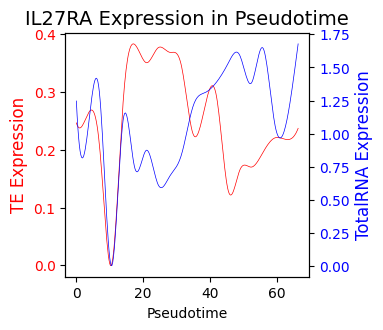

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.interpolate import make_interp_spline
plt.rcParams['svg.fonttype'] = 'none'
gene_te = adata.layers['TE'][:, adata.var_names.get_loc('IL27RA')]
gene_x = adata.X[:, adata.var_names.get_loc('IL27RA')]
gene_rbRNA = adata.layers['rbRNA'][:, adata.var_names.get_loc('IL27RA')]
pseudotime = adata.obs['Pseudotime']

n_bins = 20
bins = np.linspace(pseudotime.min(), pseudotime.max(), n_bins + 1)

te_means = np.zeros(n_bins)
x_means = np.zeros(n_bins)
rbRNA_means = np.zeros(n_bins)

for i in range(n_bins):
    mask = (pseudotime >= bins[i]) & (pseudotime < bins[i+1])
    bin_cells = np.where(mask)[0]
    
    if len(bin_cells) > 0:
        sum_totalRNA = np.sum(gene_x[bin_cells])
        sum_rbRNA = np.sum(gene_rbRNA[bin_cells])
        original_te = sum_rbRNA / sum_totalRNA if sum_totalRNA > 0 else 0
        normalized_totalRNA = gene_x[bin_cells] / np.sum(gene_x[bin_cells]) * 2203
        normalized_rbRNA = normalized_totalRNA * original_te
        log_totalRNA = np.log1p(normalized_totalRNA)
        log_rbRNA = np.log1p(normalized_rbRNA)
        log_te = np.log1p(original_te)
        te_means[i] = np.mean(log_te)
        x_means[i] = np.mean(log_totalRNA)
        rbRNA_means[i] = np.mean(log_rbRNA)

x_new = np.linspace(bins[:-1].min(), bins[:-1].max(), 300)
te_smooth = make_interp_spline(bins[:-1], te_means)(x_new)
x_smooth = make_interp_spline(bins[:-1], x_means)(x_new)

fig, ax1 = plt.subplots(figsize=(4, 4))
ax2 = ax1.twinx()

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

ax1.plot(x_new, te_smooth, color='red', label='TE', linewidth=0.5)
ax2.plot(x_new, x_smooth, color='blue', label='TotalRNA', linewidth=0.5)

ax1.set_xlabel('Pseudotime')
ax1.set_ylabel('TE Expression', color='red', fontsize=12)
ax2.set_ylabel('TotalRNA Expression', color='blue', fontsize=12)
plt.title('IL27RA Expression in Pseudotime', fontsize=14)

ax1.tick_params(axis='y', labelcolor='red', labelsize=10)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)

ax1.grid(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

plt.tight_layout()
plt.show()
#plt.savefig('IL27RA_expression_pseudotime.svg', format='svg')
plt.close()



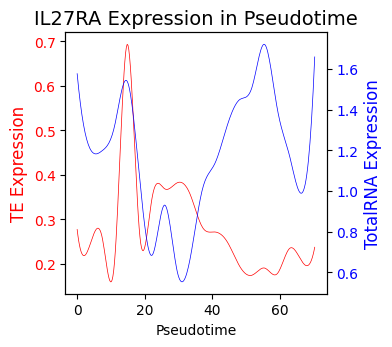

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.interpolate import make_interp_spline
plt.rcParams['svg.fonttype'] = 'none'
gene_te = adata.layers['TE'][:, adata.var_names.get_loc('IL27RA')]
gene_x = adata.X[:, adata.var_names.get_loc('IL27RA')]
gene_rbRNA = adata.layers['rbRNA'][:, adata.var_names.get_loc('IL27RA')]
pseudotime = adata.obs['Pseudotime']

n_bins = 20
bins = np.linspace(pseudotime.min(), pseudotime.max(), n_bins + 1)

te_means = np.zeros(n_bins)
x_means = np.zeros(n_bins)
rbRNA_means = np.zeros(n_bins)

for i in range(n_bins):
    mask = (pseudotime >= bins[i]) & (pseudotime < bins[i+1])
    bin_cells = np.where(mask)[0]
    
    if len(bin_cells) > 0:
        sum_totalRNA = np.sum(gene_x[bin_cells])
        sum_rbRNA = np.sum(gene_rbRNA[bin_cells])
        original_te = sum_rbRNA / sum_totalRNA if sum_totalRNA > 0 else 0
        normalized_totalRNA = gene_x[bin_cells] / np.sum(gene_x[bin_cells]) * 2203
        normalized_rbRNA = normalized_totalRNA * original_te
        log_totalRNA = np.log1p(normalized_totalRNA)
        log_rbRNA = np.log1p(normalized_rbRNA)
        log_te = np.log1p(original_te)
        te_means[i] = np.mean(log_te)
        x_means[i] = np.mean(log_totalRNA)
        rbRNA_means[i] = np.mean(log_rbRNA)

x_new = np.linspace(bins[:-1].min(), bins[:-1].max(), 300)
te_smooth = make_interp_spline(bins[:-1], te_means)(x_new)
x_smooth = make_interp_spline(bins[:-1], x_means)(x_new)

fig, ax1 = plt.subplots(figsize=(4, 4))
ax2 = ax1.twinx()

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

ax1.plot(x_new, te_smooth, color='red', label='TE', linewidth=0.5)
ax2.plot(x_new, x_smooth, color='blue', label='TotalRNA', linewidth=0.5)

ax1.set_xlabel('Pseudotime')
ax1.set_ylabel('TE Expression', color='red', fontsize=12)
ax2.set_ylabel('TotalRNA Expression', color='blue', fontsize=12)
plt.title('IL27RA Expression in Pseudotime', fontsize=14)

ax1.tick_params(axis='y', labelcolor='red', labelsize=10)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)

ax1.grid(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

plt.tight_layout()
plt.show()
#plt.savefig('IL27RA_expression_pseudotime.svg', format='svg')
plt.close()

